# Mystery Lens

In [1]:

# import standard python libraries
import numpy as np
import scipy
import os
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy



In [2]:
# import of standard python libraries and the required lenstronomy modules
#import numpy as np
#import os
#import time
#import corner
#import astropy.io.fits as pyfits
#import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#%matplotlib inline


# lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
import time

np.random.seed(41)

## Let's pretend we just got this data off the telescope.
Last time we put the subhalo in ourselves but this time we have no idea, is there one subhalo? Two? Many? We're going to explore how we try to make choices about modelling scientific data.

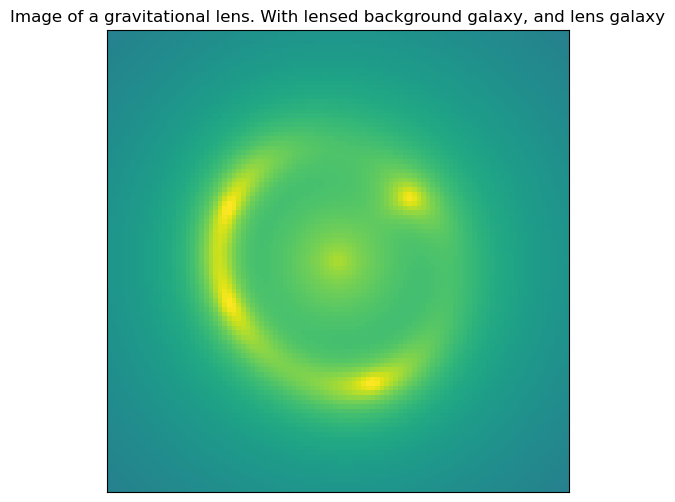

In [4]:


import pickle

kwargs_data,data_class, image_sim, kwargs_psf, kwargs_numerics = pickle.load( open('mystery_lens.pickle','rb'))





# display the initial simulated image
cmap_string = 'gray'
#cmap = plt.get_cmap(cmap_string)
#cmap = plt.cm.get_cmap("gray").copy()
#cmap.set_bad(color='k', alpha=1.)
#cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
plt.title('Image of a gravitational lens. With lensed background galaxy, and lens galaxy')

im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max,  extent=[0, 1, 0, 1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

## and here we compute the convergence at each pixel position
#x_coords, y_coords = data_class.pixel_coordinates
#kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
#plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
#plt.show()

## Q Pretend you just got the above image from the telescope. How would you decide whether this system has extra subhalos or not?
Brainstorm with your peers about what some good tests would be that you could do.


In [5]:
##### lensing quantities to adjust


###starting guesses for parameter values.
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
gamma1, gamma2 = param_util.shear_polar2cartesian(phi=0.1, gamma=0.02)# gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_shear = {'gamma1': gamma1, 'gamma2': gamma2}  
kwargs_pemd = {'theta_E': 1, 'gamma': 1.96, 'center_x':0, 'center_y':0, 'e1': 0.1, 'e2': 0.2}
kwargs_lens = [kwargs_pemd, kwargs_shear]

# add substructure

lens_model_substructure_list = ['EPL', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
#kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
#kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
#kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])

kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}

kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

### need to put in the initial guesses for the source parameters, lens parameters and the lens light parameters
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': 0.0, 'center_y': 0}
kwargs_source_init.append(kwargs_sersic_source)
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
#kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list,
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 20, 'n_iterations': 100}]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)



#kwargs_result = fitting_seq.best_fit()

print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')



from lenstronomy.Plots.model_plot import ModelPlot
print('RESULT FROM FITTING THE IMPROVED MODEL')
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

#f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

#modelPlot.data_plot(ax=axes[0,0])
#modelPlot.model_plot(ax=axes[0,1])
#modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)


modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], v_min=-6, v_max=6)
#modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
#modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
#modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()



NameError: name 'kwargs_sersic_lens' is not defined